In [3]:
import numpy as np
import os
import time

from lmfit.models import GaussianModel, Model
from sklearn.linear_model import LinearRegression
from sklearn import mixture, metrics

from shapely.geometry import Polygon

from scipy.stats.distributions import norm
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde

from matplotlib import pyplot as plt
from matplotlib import cm

from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse

from scipy import ndimage as ndi
from scipy.spatial import distance
from numpy import linalg

import skimage
from skimage import io, transform
from skimage.draw import ellipse
from skimage.color import rgb2gray
from skimage import filters
from skimage.morphology import disk
from skimage import color
from skimage import filters, util
from skimage.morphology import disk, skeletonize, ball

from PIL import Image, ImageDraw, ImageFilter, ImageOps
import copy
import cv2
import os
import sys

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.ndimage import distance_transform_edt as edt
from skimage.draw import ellipse
from skimage.measure import find_contours, approximate_polygon, subdivide_polygon
import logging
import glob
from radio_beam.commonbeam import getMinVolEllipse

from src.utils import grainPreprocess, grainShow, grainMark, grainDraw, grainApprox, grainStats, grainMorphology,grainGenerate
from src.cfg import CfgAnglesNames, CfgBeamsNames, CfgDataset


In [ ]:
def img_load_preprocess(path, img_names, h=150, k=1):
    imgs = []
    for i, class_img_names in enumerate(img_names):
        imgs.append([])
        for name in class_img_names:
            img = io.imread(path + '/' + name)
            img = grainPreprocess.image_preprocess(img, h, k)
            imgs[i].append(img)
    return imgs

In [ ]:
path = 'data/images'
all_images = np.load('data/saved np/all_images.npy', allow_pickle=True)

grain_names = np.array(
    [['Ultra_Co8.jpg'], ['Ultra_Co11.jpg'], ['Ultra_Co6_2.jpg'], ['Ultra_Co15.jpg'], ['Ultra_Co25.jpg']])
types = ['средние зерна', 'мелкие зерна', 'мелкие зерна', 'крупные зерна', 'средне-мелкие зерна']
grain_images = img_load_preprocess(path, grain_names)

### Считаем все изображения, предобработаем их и сохраним

In [ ]:
# images_dir='../data/dataset_4x/'
# images_dir='images/artif/'
# save_name='images_4x_(512,512,1).npy'
# save_name='artif.npy'

images_dir = '../data/dataset_sub_base_left/'
save_name = '(1500,1500,1)_sub_base_left'

all_images = grainPreprocess.read_preprocess_data(images_dir=images_dir, save_name=save_name,
                                                  max_images_num_per_class=90,
                                                  preprocess=True, save=True, crop_bottom=False, resize=True,
                                                  resize_shape=(1500, 1500, 1))

In [ ]:
image = io.imread('../data/dataset_sub_base_left/Ultra_Co8/Ultra_Co8-001.jpeg').astype(np.uint8)

## Распределение диаметров

In [6]:
pixel = 49.7 / 1000
# pixel_1500_1500 = 50 / 983


# images = np.load('data/saved_metadata/images_4x_preprocess.npy')
images = np.load('data/saved_metadata/images_left_(1500,1500,1)_preprocessed.npy')
# images = np.load('artif.npy')

# images = np.load('images_left_(1500,1500,1)_preprocessed.npy')
# images = np.load('data/saved_np/images_10_mixer_preprocess.npy')
names = np.load('data/saved_metadata/metadata_left_(1500,1500,1)_preprocessed.npy')
# names = np.load('data/saved_np/metadata_10_mixer_preprocess.npy')
names = [name.split('\\')[-1] for name in names]

folder = 'data/'

# path = 'data/saved np'
path = 'data/saved_metadata/'
# name = 'artif'
name = 'left_(1500,1500,1)'
# name = '10_mixer_preprocess'
# name = '4x_left_(1500,1500,1)'

types_dict = {'Ultra_Co11': 'средние зерна',
              'Ultra_Co25': 'мелкие зерна',
              'Ultra_Co8': 'средне-мелкие зерна',
              'Ultra_Co6_2': 'крупные зерна',
              'Ultra_Co15': 'средне-мелкие зерна'}

# types_dict = {'class_1': 'Type None'}

for step in range(1, 6):
    # print('step: ',step)
    grainGenerate.diametr_approx_save(path, images,name, names, types_dict, step, pixel=pixel, save=True)

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

D:\PROJECTS\python\wc_cv\src\utils.py:1248: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(f'{folder}/' + CfgBeamsNames.original_values_a + f'{name}' + f'{step}.npy', np.array(all_a_beams))
D:\PROJECTS\python\wc_cv\src\utils.py:1249: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(f'{folder}/' + CfgBeamsNames.original_values_b + f'{name}' + f'{step}.npy', np.array(all_b_beams))


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

D:\PROJECTS\python\wc_cv\src\utils.py:1248: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(f'{folder}/' + CfgBeamsNames.original_values_a + f'{name}' + f'{step}.npy', np.array(all_a_beams))
D:\PROJECTS\python\wc_cv\src\utils.py:1249: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(f'{folder}/' + CfgBeamsNames.original_values_b + f'{name}' + f'{step}.npy', np.array(all_b_beams))


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

D:\PROJECTS\python\wc_cv\src\utils.py:1248: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(f'{folder}/' + CfgBeamsNames.original_values_a + f'{name}' + f'{step}.npy', np.array(all_a_beams))
D:\PROJECTS\python\wc_cv\src\utils.py:1249: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(f'{folder}/' + CfgBeamsNames.original_values_b + f'{name}' + f'{step}.npy', np.array(all_b_beams))


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

D:\PROJECTS\python\wc_cv\src\utils.py:1248: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(f'{folder}/' + CfgBeamsNames.original_values_a + f'{name}' + f'{step}.npy', np.array(all_a_beams))
D:\PROJECTS\python\wc_cv\src\utils.py:1249: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(f'{folder}/' + CfgBeamsNames.original_values_b + f'{name}' + f'{step}.npy', np.array(all_b_beams))


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

D:\PROJECTS\python\wc_cv\src\utils.py:1248: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(f'{folder}/' + CfgBeamsNames.original_values_a + f'{name}' + f'{step}.npy', np.array(all_a_beams))
D:\PROJECTS\python\wc_cv\src\utils.py:1249: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(f'{folder}/' + CfgBeamsNames.original_values_b + f'{name}' + f'{step}.npy', np.array(all_b_beams))


In [2]:
def diametr_approx_all(folder,name, step, N, M, indices=None,save=False):
    #
    # вывод распределения длин а- и б- полуосей для разных образцов
    #

    xy_scatter = np.load(f'{folder}/' + CfgBeamsNames.values + f'{name}' + f'{step}.npy', allow_pickle=True)
    xy_linear = np.load(f'{folder}/' + CfgBeamsNames.approx + f'{name}' + f'{step}.npy', allow_pickle=True)
    xy_linear_data = np.load(f'{folder}/' + CfgBeamsNames.approx_data + f'{name}' + f'{step}.npy', allow_pickle=True)
    texts = np.load(f'{folder}/' + CfgBeamsNames.legend + f'{name}' + f'{step}.npy', allow_pickle=True)

    if indices is not None:
        xy_scatter = xy_scatter[indices]
        xy_linear = xy_linear[indices]
        xy_linear_data = xy_linear_data[indices]
        texts = texts[indices]

    plt.rcParams['font.size'] = '20'
    gs = gridspec.GridSpec(1, 2)
    # для статьи 12,18
    plt.figure(figsize=(N, M))

    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])

    # ax1.set_title('распределение a-полуосей связующего вещества', fontsize=20)
    # ax2.set_title('распределение b-полуосей связующего вещества', fontsize=20)

    ax1.set_ylabel('ln(p(x))', fontsize=15)
    ax1.set_xlabel('длина, мкм', fontsize=15)

    ax2.set_ylabel('ln(p(x))', fontsize=15)
    ax2.set_xlabel('длина, мкм', fontsize=15)

    #  ax3.grid()
    markers = ['v', 's', 'D', 'd', 'p', '*']
    for i in range(len(xy_scatter)):
        ax1.plot(xy_linear[i][0][0], xy_linear[i][0][1])
        ax2.plot(xy_linear[i][1][0], xy_linear[i][1][1])

    ax1.legend(texts[:, 0], fontsize=14, loc=1)
    # print(texts[:, 0])
    ax2.legend(texts[:, 1], fontsize=14, loc=1)
    # print(texts[:, 1])

    for i in range(len(xy_scatter)):
        marker = markers[i]
        ax1.scatter(xy_scatter[i][0][0], xy_scatter[i][0][1], marker=marker)
        ax2.scatter(xy_scatter[i][1][0], xy_scatter[i][1][1], marker=marker)

    if save:
        plt.savefig(f'распределение_полуосей_{name}_шаг_{step}')


    plt.show()


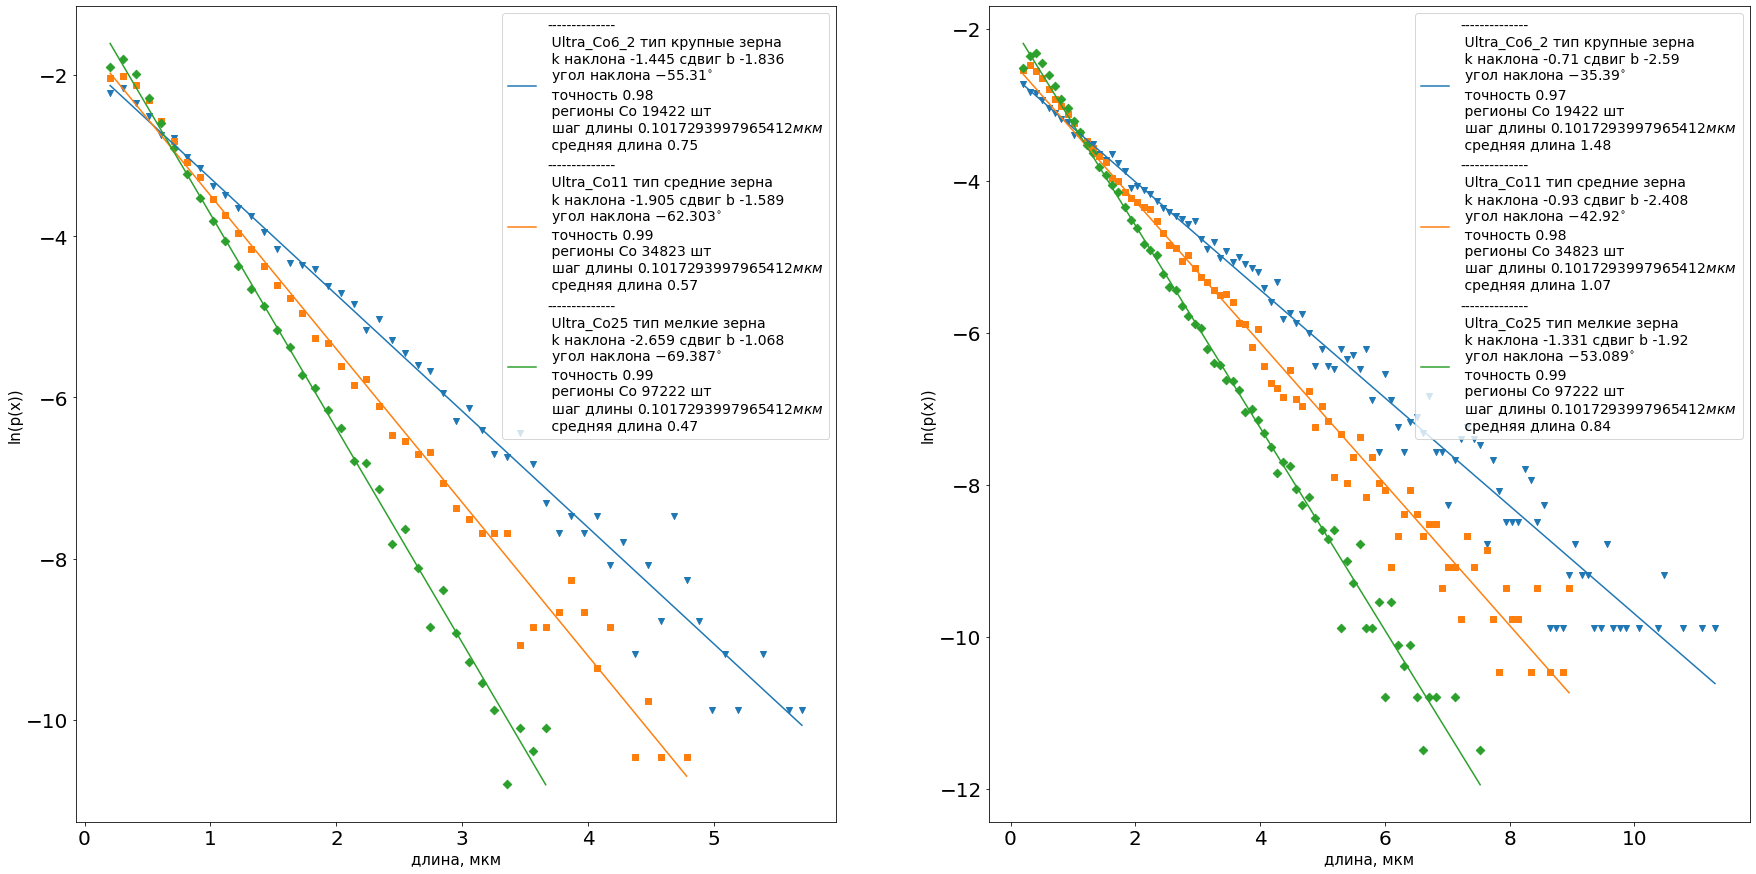

In [4]:
N = 30
M = 15
# для статье N=10,M=5

step = 2
# save=True
save=False

# folder = '../data/saved np'
# folder = 'data/saved_np'
folder = 'data/saved_metadata'
# name = '10_mixer_preprocess'
name = '4x_left_orig_shape_'
# name = '4x_data_border_fix_'
# name = ''

# types_dict = {'Ultra_Co11': 'средние зерна',
#               'Ultra_Co25': 'мелкие зерна',
#               'Ultra_Co8': 'средне-мелкие зерна',
#               'Ultra_Co6_2': 'крупные зерна',
#               'Ultra_Co15': 'средне-мелкие зерна'}




# diametr_approx_all(folder,name, step, N, M, indices=[0, 2, 3])
diametr_approx_all(folder,name, step, N, M, indices=[3,0,2],save=save)

In [133]:
import matplotlib
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [131]:
def diametr_approx_all_bidimentional(folder,name, step, N, M, indices=None,save=False):
    #
    # вывод распределения длин а- и б- полуосей для разных образцов
    #
    pixel = 49.7 / 1000
    xy_scatter = np.load(f'{folder}/' + CfgBeamsNames.values + f'{name}' + f'{step}.npy', allow_pickle=True)
    xy_linear = np.load(f'{folder}/' + CfgBeamsNames.approx + f'{name}' + f'{step}.npy', allow_pickle=True)
    xy_linear_data = np.load(f'{folder}/' + CfgBeamsNames.approx_data + f'{name}' + f'{step}.npy', allow_pickle=True)
    texts = np.load(f'{folder}/' + CfgBeamsNames.legend + f'{name}' + f'{step}.npy', allow_pickle=True)
    all_a_beams = np.load(f'{folder}/' + CfgBeamsNames.original_values_a + f'{name}' + f'{step}.npy', allow_pickle=True)
    all_b_beams = np.load(f'{folder}/' + CfgBeamsNames.original_values_b + f'{name}' + f'{step}.npy', allow_pickle=True)

    if indices is not None:
        xy_scatter = xy_scatter[indices]
        xy_linear = xy_linear[indices]
        xy_linear_data = xy_linear_data[indices]
        texts = texts[indices]
        all_a_beams = all_a_beams[indices]
        all_b_beams = all_b_beams[indices]

    plt.rcParams['font.size'] = '20'
    gs = gridspec.GridSpec(1, 2)
    # для статьи 12,18
    # plt.figure(figsize=(N, M))
    #
    # ax1 = plt.subplot(gs[0])
    # ax2 = plt.subplot(gs[1])

    # ax1.set_title('распределение a-полуосей связующего вещества', fontsize=20)
    # ax2.set_title('распределение b-полуосей связующего вещества', fontsize=20)

    # ax1.set_ylabel('ln(p(x))', fontsize=15)
    # ax1.set_xlabel('длина, мкм', fontsize=15)
    #
    # ax2.set_ylabel('ln(p(x))', fontsize=15)
    # ax2.set_xlabel('длина, мкм', fontsize=15)

    #  ax3.grid()
    markers = ['v', 's', 'D', 'd', 'p', '*']
    # for i in range(len(xy_scatter)):
    #     ax1.plot(xy_linear[i][0][0], xy_linear[i][0][1])
    #     ax2.plot(xy_linear[i][1][0], xy_linear[i][1][1])

    # ax1.legend(texts[:, 0], fontsize=14, loc=1)
    # print(texts[:, 0])
    # ax2.legend(texts[:, 1], fontsize=14, loc=1)
    # print(texts[:, 1])

    # plt.figure(figsize=(8, 8))

    left, width = 8, 2
    bottom, height = 8,2
    spacing = 0.005


    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.4]
    rect_histy = [left + width + spacing, bottom, 0.4, height]

    plt.figure(figsize=(5, 5))

    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='in', top=True, right=True)
    ax_histx = plt.axes(rect_histx)
    ax_histx.tick_params(direction='in', labelbottom=False)
    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='in', labelleft=False)

    # ax_scatter.scatter(x, y)

    for i in range(len(xy_scatter)):
        marker = markers[i]
        # ax1.scatter(xy_scatter[i][0][0], xy_scatter[i][0][1], marker=marker)
        # ax2.scatter(xy_scatter[i][1][0], xy_scatter[i][1][1], marker=marker)
        ax_scatter.scatter(np.array(all_a_beams[i])*pixel, np.array(all_b_beams[i])*pixel, marker=marker,alpha=0.5)
        ax_histx.hist(np.array(all_a_beams[i])*pixel,bins=100,alpha=0.5,log=True)
        ax_histy.hist(np.array(all_b_beams[i])*pixel,bins=100,alpha=0.5, orientation='horizontal', log=True)

    plt.legend([f'Синий - Ultra_Co6_2 крупные зерна, шаг 2 пикселя, полуосей {len(all_a_beams[0])} ',f'Оранжевый - Ultra_Co11 средние зерна, полуосей {len(all_a_beams[1])}',f'Зеленый - Ultra_Co25 мелкие зерна, полуосей {len(all_a_beams[2])}'], fontsize=14, loc='upper center')

    ax_scatter.set_xlabel('длина b-полуоси, мкм', fontsize=15)
    ax_scatter.set_ylabel('длина a-полуоси, мкм', fontsize=15)
    ax_histx.set_ylabel('ln(N)')
    ax_histy.set_xlabel('ln(N)')

    plt.savefig(f'двойной график полуосей_{name}_шаг_{step}.png')

    plt.show()

    # fig, ax = plt.subplots()
    #
    # im, cbar = heatmap(harvest, vegetables, farmers, ax=ax,
    #                    cmap="YlGn", cbarlabel="harvest [t/year]")
    # texts = annotate_heatmap(im, valfmt="{x:.1f} t")
    #
    # fig.tight_layout()
    # plt.show()
    # plt.draw()
    # if save:


In [11]:
all_a_beams = np.load(f'{folder}/' + CfgBeamsNames.original_values_a + f'{name}' + f'{step}.npy', allow_pickle=True)

In [41]:
max(all_a_beams[0])

108

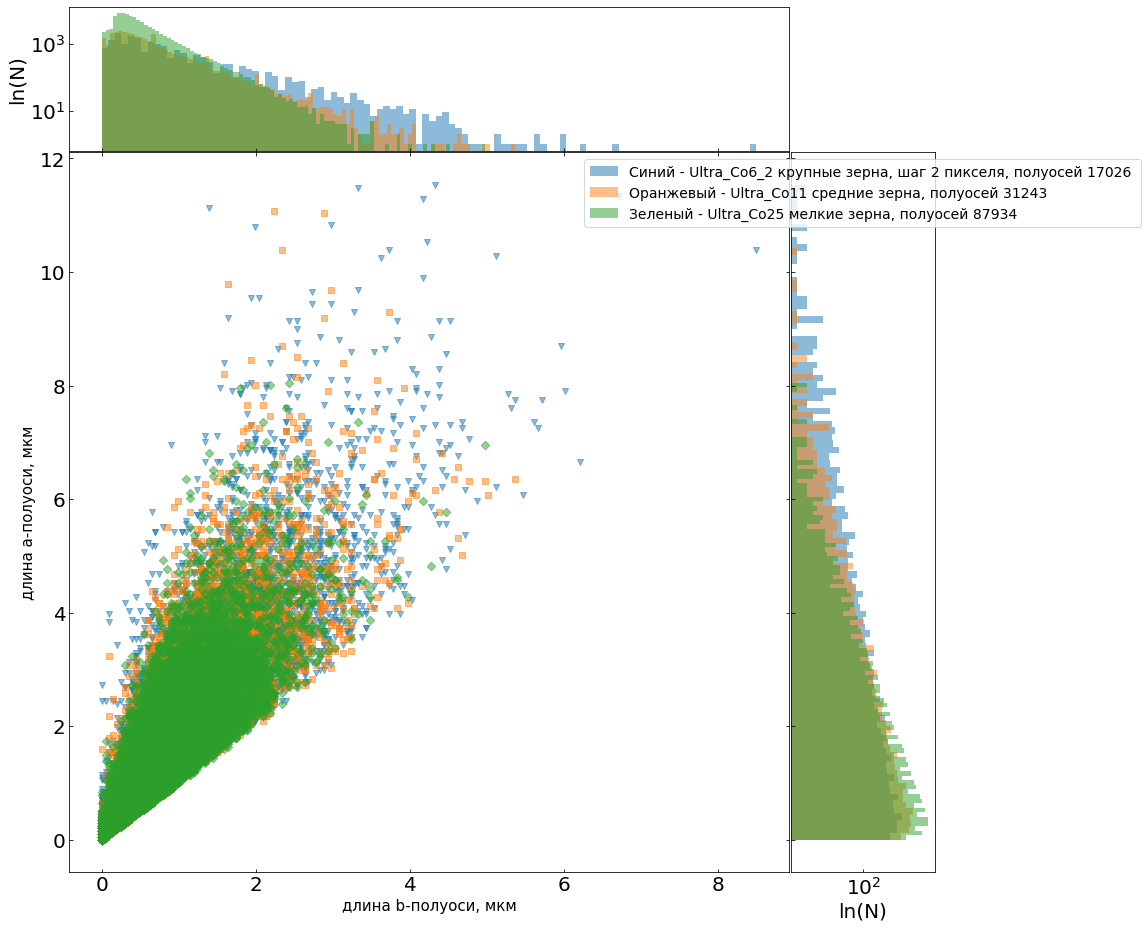

In [132]:
N = 30
M = 15
# для статье N=10,M=5

step = 2
# save=True
save=True

# folder = '../data/saved np'
# folder = 'data/saved_np'
folder = 'data/saved_metadata'
# name = '10_mixer_preprocess'
# name = '4x_left_orig_shape_'
name = 'left_(1500,1500,1)'
# name = '4x_data_border_fix_'
# name = ''

# types_dict = {'Ultra_Co11': 'средние зерна',
#               'Ultra_Co25': 'мелкие зерна',
#               'Ultra_Co8': 'средне-мелкие зерна',
#               'Ultra_Co6_2': 'крупные зерна',
#               'Ultra_Co15': 'средне-мелкие зерна'}




# diametr_approx_all(folder,name, step, N, M, indices=[0, 2, 3])
diametr_approx_all_bidimentional(folder,name, step, N, M, indices=[3,0,2],save=save)
# diametr_approx_all_bidimentional(folder,name, step, N, M, indices=[0],save=save)

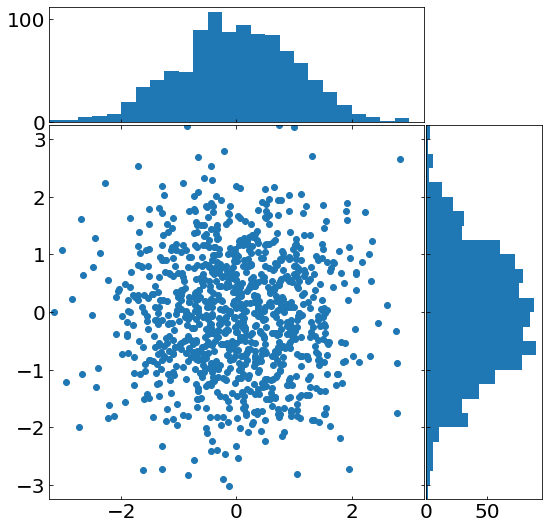

In [67]:
x = np.random.randn(1000)
y = np.random.randn(1000)

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.scatter(x, y)

# now determine nice limits by hand:
binwidth = 0.25
lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
ax_scatter.set_xlim((-lim, lim))
ax_scatter.set_ylim((-lim, lim))

bins = np.arange(-lim, lim + binwidth, binwidth)
ax_histx.hist(x, bins=bins)
ax_histy.hist(y, bins=bins, orientation='horizontal')

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

plt.show()

### Вывод на снимке ненормалных углов

In [ ]:
def draw_edges(image, tol=3, border_eps=5):
    #
    # рисует на изображении линии по точкам контура cnts
    # линии в стиле x^1->x^2,x^2->x^3 и тд
    # на вход подавать обработанное изображение
    #
    new_image = image[:, :, 0]
    im = Image.fromarray(np.uint8(new_image)).convert('RGB')
    draw = ImageDraw.Draw(im)

    cnts = grainMark.get_row_contours(image)
    angles = []

    for j, cnt in enumerate(cnts):
        rules = [image.shape[0] - cnt[:, 0].max() > border_eps, cnt[:, 0].min() > border_eps,
                 image.shape[1] - cnt[:, 1].max() > border_eps, cnt[:, 1].min() > border_eps]
        # проверяем находится ли контур у границы, но это срабатывает очень редко
        if all(rules):
            cnt_aprox = approximate_polygon(cnt, tolerance=tol)
            # основная проверка на неправильные контуры
            if len(cnt_aprox) > 3:
                for i, point in enumerate(cnt_aprox[:-1]):

                    y1, x1 = cnt_aprox[i - 1]
                    y2, x2 = cnt_aprox[i]
                    y3, x3 = cnt_aprox[i + 1]

                    v1 = np.array((x1 - x2, y1 - y2)).reshape(1, 2)
                    v2 = np.array((x3 - x2, y3 - y2)).reshape(1, 2)

                    dot = np.dot(v1[0], v2[0])
                    dist1 = np.linalg.norm(v1[0])
                    dist2 = np.linalg.norm(v2[0])
                    cos = dot / (dist1 * dist2)

                    v = np.concatenate([v1, v2])
                    det = np.linalg.det(v)

                    if abs(cos) < 1:
                        ang = int(np.arccos(cos) * 180 / np.pi)

                        if det < 0:
                            angles.append(ang)
                        else:
                            angles.append(360 - ang)
                    else:
                        if det < 0:
                            angles.append(360)
                            ang = 360
                        else:
                            angles.append(0)
                            ang = 0

                    line_color = (0, 255, 127)

                    if ang <= 30:
                        color = (0, 0, 255)
                        r = 4
                        draw.ellipse((y2 - r, x2 - r, y2 + r, x2 + r), fill=color, width=5)
                        draw.line((y1, x1, y2, x2), fill=line_color, width=4)
                        draw.line((y3, x3, y2, x2), fill=line_color, width=4)

                    elif ang >= 30:
                        color = (255, 0, 0)
                        r = 4
                        draw.ellipse((y2 - r, x2 - r, y2 + r, x2 + r), fill=color, width=5)
                        # draw.line((y1, x1, y2, x2), fill=line_color, width=4)
                        # draw.line((y3, x3, y2, x2), fill=line_color, width=4)


        else:
            continue

    img = np.array(im)

    return img, angles

In [ ]:
# img=io.imread('../data/dataset_4x/Ultra_Co8/Ultra_Co8-001_1.jpeg')
i = 0
img = np.load('data/artif.npy')[1, i]
tol = 3
border_eps = 5
im, angles = draw_edges(img, tol, border_eps)
io.imsave(f'low_angles_artif.png', im)
grainShow.img_show(im, 10, cmap='gray')
